##### Feature Selection

Perform feature selection using the GradientBoosting model and dataset determined in model training

Basic Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

Model imports

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV

import warnings

Define evaluate_model function as in Model training

In [3]:
def evaluate_model(true, predicted, model, X_test):
    precision = precision_score(true, predicted , zero_division = 0)
    recall = recall_score(true, predicted , zero_division = 0)
    f1 = f1_score(true , predicted, zero_division = 0)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(true, y_pred_proba)
    pr_auc = average_precision_score(true, y_pred_proba)
    return precision, recall, f1, roc_auc, pr_auc

Load in the unscaled and balanced datasets

In [4]:
X_train=pd.read_csv('data/unscaled_balanced_X_train.csv')
y_train=pd.read_csv('data/unscaled_balanced_y_train.csv')

In [6]:
X_train.shape

(200000, 20)

Load in the test datasets

In [5]:
X_test=pd.read_csv('data/X_test.csv')
y_test=pd.read_csv('data/y_test.csv')

In [7]:
X_test.shape

(50736, 20)

Define GradientBoosting Classifier as baseline and run it.
Also output feature importance

In [17]:
models = {
     "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42)
}
# define empty list
model_list = []
r2_list =[]

# for every model in the list
for i in range(len(list(models))):
    # set model to model at index i
    model = list(models.values())[i]

    # Train model
    model.fit(X_train, y_train) 

    # Get predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Make predictions
    y_train_pred = model.predict(X_train)
    accuracy_train = accuracy_score(y_train , y_train_pred)

    y_test_pred = model.predict(X_test)
    accuracy_test = accuracy_score(y_test , y_test_pred)

    model_train_precision, model_train_recall, model_train_f1, model_train_roc_auc, model_train_pr_auc = evaluate_model(y_train, y_train_pred, model, X_train)
    model_test_precision, model_test_recall, model_test_f1, model_test_roc_auc, model_test_pr_auc = evaluate_model(y_test, y_test_pred, model, X_test)

    print(list(models.keys())[i])

    # append each model to model_list
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Training Accuracy: {:.4f}".format(accuracy_train))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- F1 Score: {:.4f}".format(model_train_f1))
    print("- ROC_AUC: {:.4f}".format(model_train_roc_auc))
    print("- PR_AUC: {:.4f}".format(model_train_pr_auc))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Testing Accuracy: {:.4f}".format(accuracy_test))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- F1 Score: {:.4f}".format(model_test_f1))
    print("- ROC_AUC: {:.4f}".format(model_test_roc_auc))
    print("- PR_AUC: {:.4f}".format(model_test_pr_auc))

    print('='*35)
    print('\n')

    # Extract feature importances from Gradient Boosting Classifier
    importances = model.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.Series(importances, index=feature_names)

    # sort feature importances and names
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    feature_names_sorted = feature_importances_sorted.index

    print(feature_importances_sorted)

c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gradient Boosting Classifier
Model performance for Training set
- Training Accuracy: 0.8517
- Precision: 0.8693
- Recall: 0.8277
- F1 Score: 0.8480
- ROC_AUC: 0.9350
- PR_AUC: 0.9451
----------------------------------
Model performance for Test set
- Testing Accuracy: 0.8198
- Precision: 0.4374
- Recall: 0.5297
- F1 Score: 0.4792
- ROC_AUC: 0.8255
- PR_AUC: 0.4513


HighBP                  0.363873
GenHlth                 0.206735
HighChol                0.141802
BMI                     0.054032
Age                     0.047864
Sex                     0.031812
HeartDiseaseorAttack    0.022830
DiffWalk                0.022613
PhysActivity            0.018519
Smoker                  0.016729
Education               0.016006
Fruits                  0.014376
Income                  0.010403
HvyAlcoholConsump       0.010169
Veggies                 0.008011
MentHlth                0.004296
PhysHlth                0.004099
CholCheck               0.003816
Stroke                  0.001664
AnyH

Observation:
Highest feature importance:
HighBP                  0.363873
GenHlth                 0.206735
HighChol                0.141802
BMI                     0.054032
Age                     0.047864

Lowest feature importance:
MentHlth                0.004296
PhysHlth                0.004099
CholCheck               0.003816
Stroke                  0.001664
AnyHealthcare           0.000354

These results fit what I would expect. 



Try iterative feature removal results. Iteratively remove 2 least important features from the feature importance sorted list

In [18]:
def iterative_feature_removal(X_train, y_train, X_test, y_test, feature_importance_sorted):
    """
    Iteratively remove 2 least important features and retrain GradientBoost model until 0 features.
    
    Parameters:
    -----------
    X_train, y_train : Training data and target
    X_test, y_test : Test data and target
    feature_importance_sorted : DataFrame with features sorted by importance (most to least)
    
    Returns:
    --------
    results_df : DataFrame with model performance metrics at each iteration
    """
    
    # Initialize results list
    results = []
    
    # Get list of features from most to least important
    features_list = feature_importance_sorted.index.tolist()  # or feature_importance_sorted['feature'].tolist() depending on your df structure
    
    # Start with all features
    current_features = features_list.copy()
    
    iteration = 0
    while len(current_features) > 0:
        print(f"\n{'='*50}")
        print(f"Iteration {iteration + 1}: Training with {len(current_features)} features")
        print(f"{'='*50}")
        
        # Select current features for training and testing
        X_train_subset = X_train[current_features]
        X_test_subset = X_test[current_features]
        
        # Train model
        model = GradientBoostingClassifier(random_state=42)
        model.fit(X_train_subset, y_train)
        
        # Get predictions
        y_train_pred = model.predict(X_train_subset)
        y_test_pred = model.predict(X_test_subset)
        y_test_pred_proba = model.predict_proba(X_test_subset)[:, 1]
        
        # Calculate metrics for training set
        train_acc = accuracy_score(y_train, y_train_pred)
        train_precision, train_recall, train_f1, train_roc_auc, train_pr_auc = evaluate_model(
            y_train, y_train_pred, model, X_train_subset
        )
        
        # Calculate metrics for test set
        test_acc = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, zero_division=0)
        test_recall = recall_score(y_test, y_test_pred, zero_division=0)
        test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
        test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
        test_pr_auc = average_precision_score(y_test, y_test_pred_proba)
        
        # Store results
        results.append({
            'num_of_features': len(current_features),
            'training_acc': train_acc,
            'test_acc': test_acc,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1,
            'roc_auc': test_roc_auc,
            'pr_auc': test_pr_auc
        })
        
        # Print current results
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Precision: {test_precision:.4f}")
        print(f"Recall: {test_recall:.4f}")
        print(f"F1 Score: {test_f1:.4f}")
        print(f"ROC AUC: {test_roc_auc:.4f}")
        print(f"PR AUC: {test_pr_auc:.4f}")
        
        # Remove 2 least important features for next iteration
        if len(current_features) > 2:
            current_features = current_features[:-2]  # Remove last 2 features (least important)
        elif len(current_features) == 2:
            current_features = current_features[:-2]  # Remove both remaining features
        else:
            current_features = []  # Remove the last feature
        
        iteration += 1
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Reorder columns
    results_df = results_df[['num_of_features', 'training_acc', 'test_acc', 
                             'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']]
    
    return results_df

Run the iterative feature removal

In [19]:
results_df = iterative_feature_removal(X_train, y_train, X_test, y_test, feature_importances_sorted)

# Display results
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))


Iteration 1: Training with 20 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8517
Test Accuracy: 0.8198
Precision: 0.4374
Recall: 0.5297
F1 Score: 0.4792
ROC AUC: 0.8255
PR AUC: 0.4513

Iteration 2: Training with 18 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8514
Test Accuracy: 0.8192
Precision: 0.4364
Recall: 0.5317
F1 Score: 0.4793
ROC AUC: 0.8255
PR AUC: 0.4510

Iteration 3: Training with 16 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8510
Test Accuracy: 0.8192
Precision: 0.4361
Recall: 0.5286
F1 Score: 0.4779
ROC AUC: 0.8246
PR AUC: 0.4504

Iteration 4: Training with 14 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8502
Test Accuracy: 0.8195
Precision: 0.4368
Recall: 0.5297
F1 Score: 0.4787
ROC AUC: 0.8252
PR AUC: 0.4515

Iteration 5: Training with 12 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8491
Test Accuracy: 0.8184
Precision: 0.4336
Recall: 0.5236
F1 Score: 0.4744
ROC AUC: 0.8228
PR AUC: 0.4470

Iteration 6: Training with 10 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8437
Test Accuracy: 0.8147
Precision: 0.4277
Recall: 0.5433
F1 Score: 0.4786
ROC AUC: 0.8224
PR AUC: 0.4494

Iteration 7: Training with 8 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8372
Test Accuracy: 0.8092
Precision: 0.4189
Recall: 0.5652
F1 Score: 0.4811
ROC AUC: 0.8224
PR AUC: 0.4499

Iteration 8: Training with 6 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8319
Test Accuracy: 0.8006
Precision: 0.4063
Recall: 0.5939
F1 Score: 0.4825
ROC AUC: 0.8218
PR AUC: 0.4497

Iteration 9: Training with 4 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8116
Test Accuracy: 0.7916
Precision: 0.3903
Recall: 0.5901
F1 Score: 0.4699
ROC AUC: 0.8054
PR AUC: 0.4287

Iteration 10: Training with 2 features


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.7785
Test Accuracy: 0.7620
Precision: 0.3486
Recall: 0.5994
F1 Score: 0.4408
ROC AUC: 0.7719
PR AUC: 0.3406

FINAL RESULTS SUMMARY
 num_of_features  training_acc  test_acc  precision   recall       f1  roc_auc   pr_auc
              20      0.851655  0.819773   0.437441 0.529656 0.479152 0.825471 0.451277
              18      0.851355  0.819221   0.436382 0.531671 0.479337 0.825451 0.451046
              16      0.850965  0.819241   0.436111 0.528649 0.477942 0.824604 0.450404
              14      0.850250  0.819477   0.436760 0.529656 0.478743 0.825204 0.451478
              12      0.849055  0.818393   0.433622 0.523612 0.474387 0.822782 0.446963
              10      0.843655  0.814747   0.427722 0.543257 0.478615 0.822435 0.449350
               8      0.837235  0.809208   0.418852 0.565168 0.481132 0.822429 0.449873
               6      0.831950  0.800595   0.406272 0.593880 0.482480 0.821823 0.449705
               4      0.811580  0.791588   0.390337 0.59

Observations:
* Even with just 6 features total, the model has very similar roc_auc to when it had all 20 features. The PR_AUC drops more at around 12 features.

* The test accuracy remains quite consistent, dropping a little at 8 features 

* The best roc_auc is with all 20 features, however model performance is still relativley similar across the metrics up to 6 features.

Define and run a function to run recursive feature elimination with cross validation to determine optimal features

RECURSIVE FEATURE ELIMINATION WITH CROSS-VALIDATION (RFECV)

Fitting RFECV...
Starting with 20 features



c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to


Optimal number of features: 18
Features removed: 2

Selected features (18):
  1. HighBP
  2. HighChol
  3. CholCheck
  4. BMI
  5. Smoker
  6. HeartDiseaseorAttack
  7. PhysActivity
  8. Fruits
  9. Veggies
  10. HvyAlcoholConsump
  11. GenHlth
  12. MentHlth
  13. PhysHlth
  14. DiffWalk
  15. Sex
  16. Age
  17. Education
  18. Income

Eliminated features (2):
  1. Stroke
  2. AnyHealthcare

MODEL PERFORMANCE WITH SELECTED FEATURES


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Number of Features: 18
Training Accuracy: 0.8514
Test Accuracy: 0.8192
Precision: 0.4364
Recall: 0.5317
F1 Score: 0.4793
ROC AUC: 0.8255
PR AUC: 0.4510


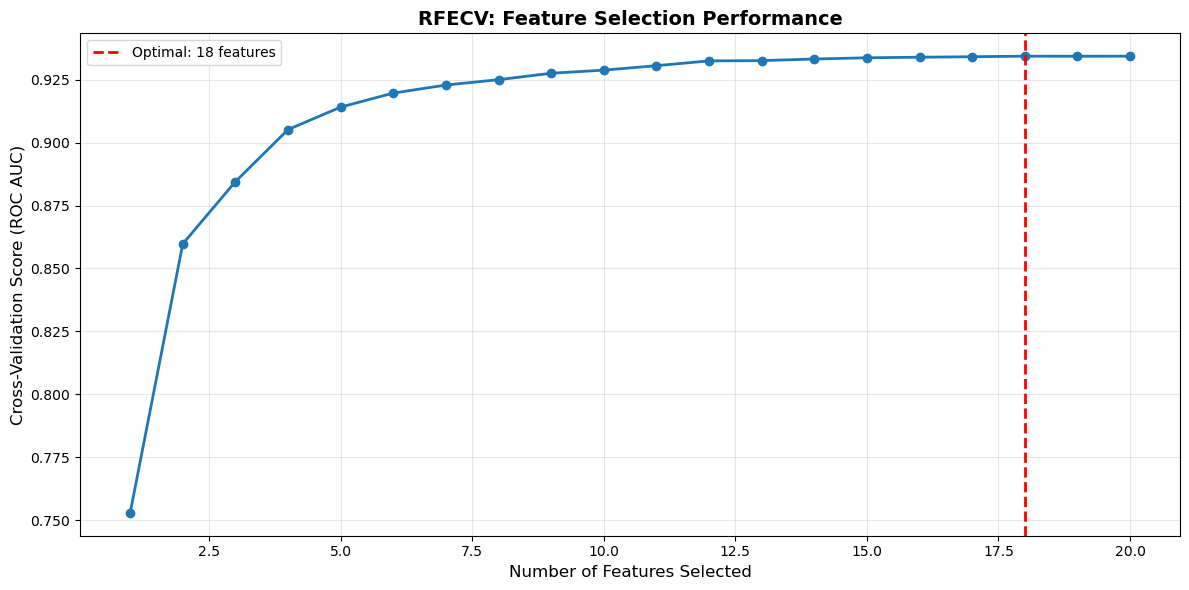


FEATURE RANKING
             Feature  Ranking  Selected
              HighBP        1      True
                 Age        1      True
                 Sex        1      True
            DiffWalk        1      True
            PhysHlth        1      True
            MentHlth        1      True
             GenHlth        1      True
   HvyAlcoholConsump        1      True
           Education        1      True
             Veggies        1      True
        PhysActivity        1      True
HeartDiseaseorAttack        1      True
              Smoker        1      True
                 BMI        1      True
           CholCheck        1      True
            HighChol        1      True
              Fruits        1      True
              Income        1      True
              Stroke        2     False
       AnyHealthcare        3     False

RFECV FINAL RESULTS
 num_of_features  training_acc  test_acc  precision   recall       f1  roc_auc   pr_auc
              18      0.851355  0.

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

def rfecv_feature_selection(X_train, y_train, X_test, y_test):
    """
    Perform Recursive Feature Elimination with Cross-Validation (RFECV) on GB model.
    
    Parameters:
    -----------
    X_train, y_train : Training data and labels
    X_test, y_test : Test data and labels
    
    Returns:
    --------
    rfecv : Fitted RFECV object
    results_df : DataFrame with performance metrics using selected features
    """
    
    print("="*80)
    print("RECURSIVE FEATURE ELIMINATION WITH CROSS-VALIDATION (RFECV)")
    print("="*80)
    
    # Initialize the model
    gb_model = GradientBoostingClassifier(random_state=42)
    
    # Initialize RFECV with 5-fold cross-validation
    # Using StratifiedKFold to maintain class distribution in each fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    rfecv = RFECV(
        estimator=gb_model,
        step=1,  # Remove 1 feature at each iteration
        cv=cv,
        scoring='roc_auc',  # You can change this to 'accuracy', 'f1', etc.
        min_features_to_select=1,
        n_jobs=-1  # Use all available cores
    )
    
    print("\nFitting RFECV...")
    print(f"Starting with {X_train.shape[1]} features\n")
    
    # Fit RFECV
    rfecv.fit(X_train, y_train)
    
    # Print results
    print(f"\nOptimal number of features: {rfecv.n_features_}")
    print(f"Features removed: {X_train.shape[1] - rfecv.n_features_}")
    
    # Get selected feature names
    selected_features = X_train.columns[rfecv.support_].tolist()
    print(f"\nSelected features ({len(selected_features)}):")
    for i, feat in enumerate(selected_features, 1):
        print(f"  {i}. {feat}")
    
    # Get eliminated feature names
    eliminated_features = X_train.columns[~rfecv.support_].tolist()
    if eliminated_features:
        print(f"\nEliminated features ({len(eliminated_features)}):")
        for i, feat in enumerate(eliminated_features, 1):
            print(f"  {i}. {feat}")
    
    # Transform training and test sets to use only selected features
    X_train_selected = rfecv.transform(X_train)
    X_test_selected = rfecv.transform(X_test)
    
    print("\n" + "="*80)
    print("MODEL PERFORMANCE WITH SELECTED FEATURES")
    print("="*80)
    
    # Train final model with selected features
    final_model = GradientBoostingClassifier(random_state=42)
    final_model.fit(X_train_selected, y_train)
    
    # Get predictions
    y_train_pred = final_model.predict(X_train_selected)
    y_test_pred = final_model.predict(X_test_selected)
    y_test_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]
    
    # Calculate metrics for training set
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # Calculate metrics for test set
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    test_pr_auc = average_precision_score(y_test, y_test_pred_proba)
    
    # Create results dictionary
    results = {
        'num_of_features': rfecv.n_features_,
        'training_acc': train_acc,
        'test_acc': test_acc,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'roc_auc': test_roc_auc,
        'pr_auc': test_pr_auc
    }
    
    # Print results
    print(f"\nNumber of Features: {results['num_of_features']}")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"ROC AUC: {test_roc_auc:.4f}")
    print(f"PR AUC: {test_pr_auc:.4f}")
    
    # Create DataFrame
    results_df = pd.DataFrame([results])
    
    # Plot cross-validation scores
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
             rfecv.cv_results_['mean_test_score'], 
             marker='o', linewidth=2, markersize=6)
    plt.xlabel('Number of Features Selected', fontsize=12)
    plt.ylabel('Cross-Validation Score (ROC AUC)', fontsize=12)
    plt.title('RFECV: Feature Selection Performance', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axvline(x=rfecv.n_features_, color='r', linestyle='--', 
                label=f'Optimal: {rfecv.n_features_} features', linewidth=2)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Create feature ranking DataFrame
    feature_ranking_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Ranking': rfecv.ranking_,
        'Selected': rfecv.support_
    }).sort_values('Ranking')
    
    print("\n" + "="*80)
    print("FEATURE RANKING")
    print("="*80)
    print(feature_ranking_df.to_string(index=False))
    
    return rfecv, results_df, selected_features, feature_ranking_df

# Run RFECV
rfecv_model, rfecv_results, selected_features, feature_ranking = rfecv_feature_selection(
    X_train, y_train, X_test, y_test
)

# Display final results
print("\n" + "="*80)
print("RFECV FINAL RESULTS")
print("="*80)
print(rfecv_results.to_string(index=False))

# Access the transformed datasets if needed
X_train_rfecv = rfecv_model.transform(X_train)
X_test_rfecv = rfecv_model.transform(X_test)

print(f"\nOriginal shape: {X_train.shape}")
print(f"Transformed shape: {X_train_rfecv.shape}")

Observation: Optimal model is with 18 features and two feature removed: Stroke and AnyHealthcare

This makes sense because these two features had the lowest feature importance score. 

Removing the feature as determined by RFECV for both X_train and X_test

In [21]:
X_train = X_train.drop(['Stroke', 'AnyHealthcare'], axis=1)
X_test = X_test.drop(['Stroke', 'AnyHealthcare'], axis=1)

Verify new feature shapes

In [22]:
X_train.shape

(200000, 18)

In [23]:
X_test.shape

(50736, 18)

Output the finalized csv

In [24]:
X_train.to_csv("data/final_X_train.csv", index=False)
X_test.to_csv("data/final_X_test.csv", index=False)